In [6]:
!pip install -q --upgrade "httpx[http2]" tqdm pandas matplotlib datasets tiktoken transformers seaborn


In [7]:
VLLM = "https://llama3-vllm-vs-tgis.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
TGI  = "https://llama3-default.apps.cluster-jj67w.jj67w.sandbox1788.opentlc.com"
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"

WARMUP_SECS = 20          # settle CUDA graphs / flash-cache
DUR_SECS    = 40          # measurement window
CONCURRENCY = [1, 4, 8, 16, 32]

HEADERS = {"Content-Type": "application/json"}


In [8]:
from datasets import load_dataset
import random, textwrap, os

LOCAL_PROMPT_FILE = "prompts.txt"

# Load from disk if file exists
if os.path.exists(LOCAL_PROMPT_FILE):
    with open(LOCAL_PROMPT_FILE, "r") as f:
        prompts = [line.strip() for line in f if line.strip()]
    print(f"✅ Loaded {len(prompts)} prompts from {LOCAL_PROMPT_FILE}")
else:
    # Download from Hugging Face and save locally
    dataset = load_dataset("wikipedia", "20220301.en", split="train[:1%]").shuffle(seed=42)
    prompts = dataset["text"][:1000]
    with open(LOCAL_PROMPT_FILE, "w") as f:
        for prompt in prompts:
            f.write(prompt.replace('\n', ' ') + "\n")
    print(f"📥 Downloaded and saved {len(prompts)} prompts to {LOCAL_PROMPT_FILE}")


✅ Loaded 1000 prompts from prompts.txt


In [9]:
import httpx, warnings, json, re
warnings.filterwarnings("ignore", message="Unverified HTTPS")

def discover(base):
    probes = [("/v1/chat/completions", {"model":MODEL_ID,"messages":[{"role":"user","content":"Hi"}],"stream":False}),
              ("/v1/completions",      {"model":MODEL_ID,"prompt":"Hi","stream":False}),
              ("/generate",            {"prompt":"Hi","max_tokens":4})]
    for p,body in probes:
        try:
            r=httpx.post(base+p,headers=HEADERS,json=body,timeout=10,verify=False)
            if r.status_code==200:
                return p,body
        except Exception: pass
    raise RuntimeError(f"No working path on {base}")

VLLM_PATH,VLLM_BODY = discover(VLLM); TGI_PATH,TGI_BODY = discover(TGI)
print("vLLM →",VLLM_PATH,"\nTGI  →",TGI_PATH)


vLLM → /v1/chat/completions 
TGI  → /v1/chat/completions



🚀 Benchmarking at concurrency=4

🚀 Benchmarking at concurrency=8

🚀 Benchmarking at concurrency=16

🚀 Benchmarking at concurrency=32

🚀 Benchmarking at concurrency=64

🚀 Benchmarking at concurrency=128

✅ Benchmarking complete.



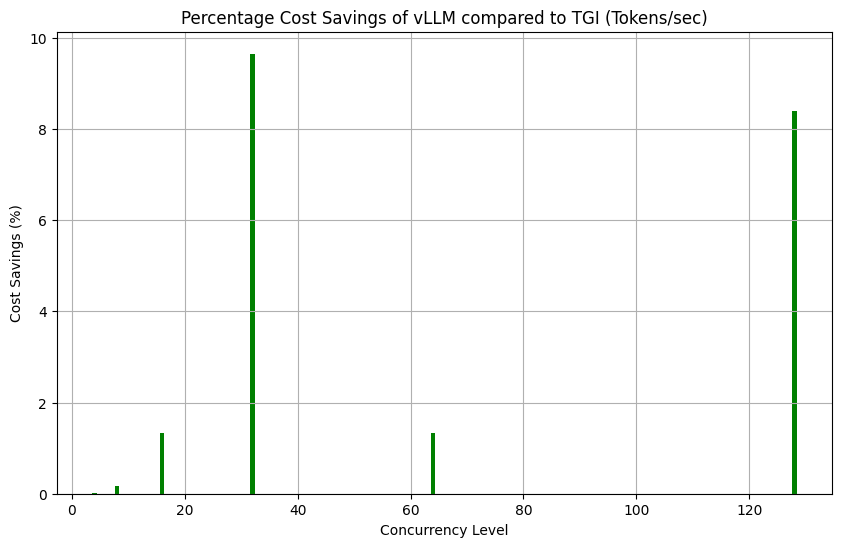

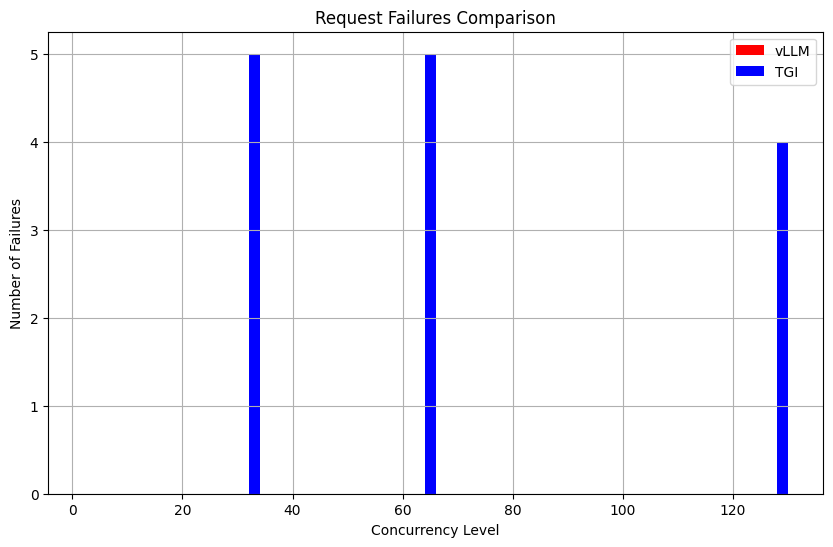

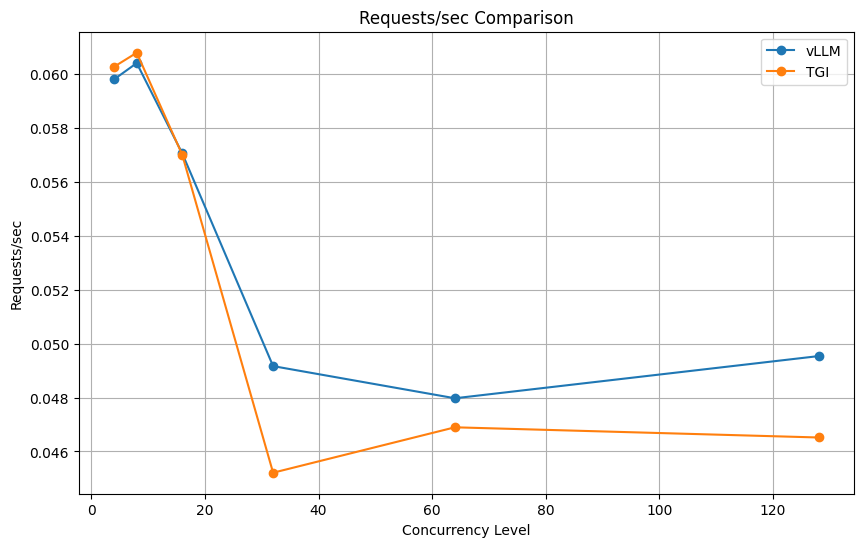

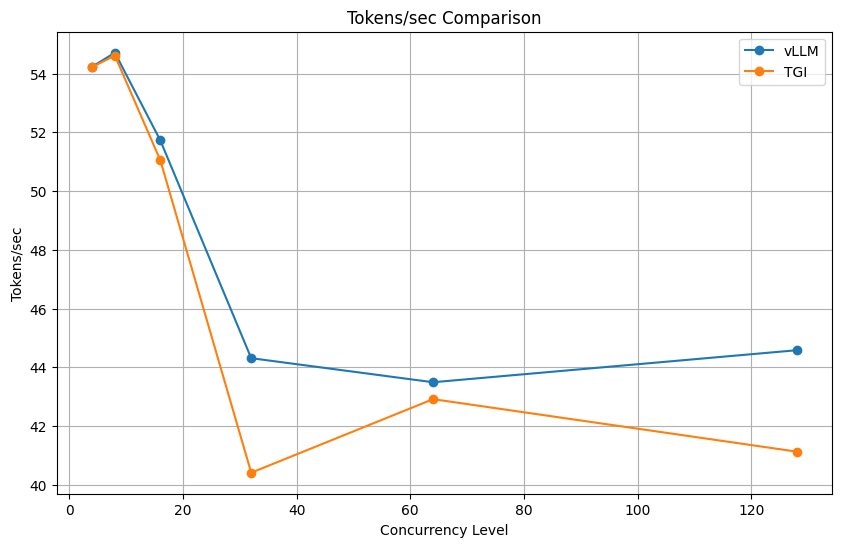

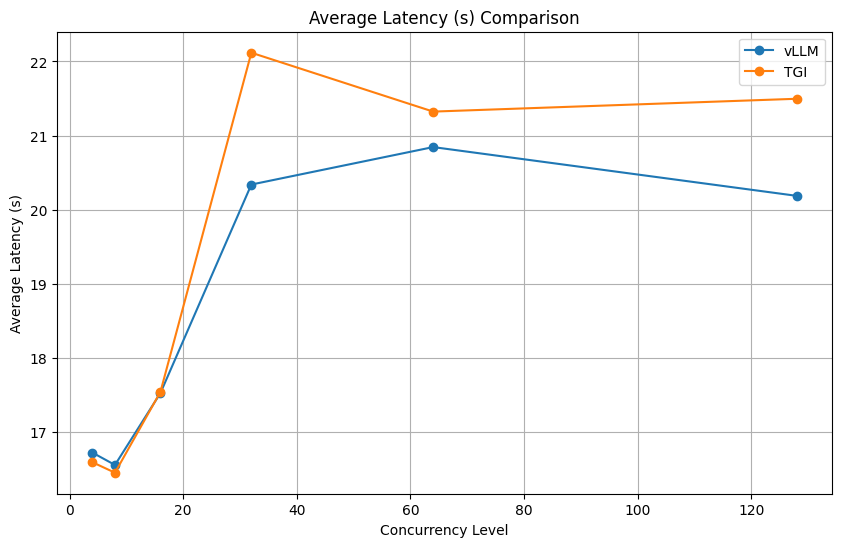

In [10]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
import httpx
import random
import time
import numpy as np
import matplotlib.pyplot as plt

MAX_PROMPT_CHARS = 3000
NUM_PROMPTS = 30
CONCURRENCY_LEVELS = [4, 8, 16, 32, 64, 128]
HTTP_TIMEOUT = 180  # Increase timeout to avoid 504 errors

async def send_request(client, url, body):
    start = time.time()
    try:
        resp = await client.post(url, headers=HEADERS, json=body, timeout=HTTP_TIMEOUT)
        duration = time.time() - start
        tokens = 0
        if resp.status_code == 200:
            data = resp.json()
            usage = data.get('usage', {})
            tokens = usage.get('prompt_tokens', 0) + usage.get('completion_tokens', 0)
            return duration, tokens, True
        else:
            return None, 0, False
    except httpx.RequestError as e:
        return None, 0, False

async def run_benchmark(name, url, path, body_template, prompts, concurrency, results_dict):
    durations = []
    tokens_total = 0
    failures = 0
    sem = asyncio.Semaphore(concurrency)

    async def bound_request(prompt):
        nonlocal tokens_total, failures
        async with sem:
            body = body_template.copy()
            if "messages" in body:
                body["messages"] = [{"role": "user", "content": prompt}]
            elif "prompt" in body:
                body["prompt"] = prompt
            body["max_tokens"] = 256
            duration, tokens, success = await send_request(client, url + path, body)
            if success:
                durations.append(duration)
                tokens_total += tokens
            else:
                failures += 1

    async with httpx.AsyncClient(timeout=HTTP_TIMEOUT, verify=False) as client:
        tasks = [bound_request(p) for p in prompts]
        await asyncio.gather(*tasks)

    successful_requests = len(durations)

    if successful_requests:
        results_dict[concurrency] = {
            'avg_latency': np.mean(durations),
            'req_per_sec': successful_requests / sum(durations),
            'tokens_per_sec': tokens_total / sum(durations),
            'failures': failures,
        }
    else:
        results_dict[concurrency] = {
            'avg_latency': np.nan,
            'req_per_sec': 0,
            'tokens_per_sec': 0,
            'failures': failures,
        }

# Generate test prompts
test_prompts = [p[:MAX_PROMPT_CHARS] for p in random.sample(prompts, NUM_PROMPTS)]

all_results = {'vLLM': {}, 'TGI': {}}

for concurrency in CONCURRENCY_LEVELS:
    print(f"\n🚀 Benchmarking at concurrency={concurrency}")

    tasks = [
        run_benchmark('vLLM', VLLM, VLLM_PATH, VLLM_BODY, test_prompts, concurrency, all_results['vLLM']),
        run_benchmark('TGI', TGI, TGI_PATH, TGI_BODY, test_prompts, concurrency, all_results['TGI'])
    ]

    await asyncio.gather(*tasks)

print("\n✅ Benchmarking complete.\n")

# Compute percentage cost savings based on throughput (tokens/sec)
valid_concurrencies = [c for c in CONCURRENCY_LEVELS if c in all_results['vLLM'] and c in all_results['TGI']]
vllm_tokens_sec = np.array([all_results['vLLM'][c]['tokens_per_sec'] for c in valid_concurrencies])
tgi_tokens_sec = np.array([all_results['TGI'][c]['tokens_per_sec'] for c in valid_concurrencies])

# Calculate savings: How much vLLM saves compared to TGI
savings_percent = 100 * (vllm_tokens_sec - tgi_tokens_sec) / tgi_tokens_sec

# Plot Percentage Cost Savings
plt.figure(figsize=(10, 6))
plt.bar(valid_concurrencies, savings_percent, color='green')
plt.axhline(0, color='black', linewidth=0.7)
plt.xlabel('Concurrency Level')
plt.ylabel('Cost Savings (%)')
plt.title('Percentage Cost Savings of vLLM compared to TGI (Tokens/sec)')
plt.grid(True)
plt.show()

# Plot Failures
failures_vllm = [all_results['vLLM'][c]['failures'] for c in valid_concurrencies]
failures_tgi = [all_results['TGI'][c]['failures'] for c in valid_concurrencies]

plt.figure(figsize=(10, 6))
plt.bar(valid_concurrencies, failures_vllm, width=-2, align='edge', label='vLLM', color='red')
plt.bar(valid_concurrencies, failures_tgi, width=2, align='edge', label='TGI', color='blue')
plt.xlabel('Concurrency Level')
plt.ylabel('Number of Failures')
plt.title('Request Failures Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Additional plots
metrics = ['req_per_sec', 'tokens_per_sec', 'avg_latency']
titles = ['Requests/sec', 'Tokens/sec', 'Average Latency (s)']

for metric, title in zip(metrics, titles):
    plt.figure(figsize=(10, 6))
    plt.plot(valid_concurrencies, [all_results['vLLM'][c][metric] for c in valid_concurrencies], marker='o', label='vLLM')
    plt.plot(valid_concurrencies, [all_results['TGI'][c][metric] for c in valid_concurrencies], marker='o', label='TGI')
    plt.xlabel('Concurrency Level')
    plt.ylabel(title)
    plt.title(f'{title} Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
